In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/calc_value_growth_history.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Fees'):
        fnames['Fees'] = fname                
fnames

{'AUM & Glp Supply': 'AUM & Glp Supply_2022-01-06_2022-07-31.csv',
 'Fees': 'Fees_2022-01-06_2022-07-31.csv',
 'Glp Price Comparison': 'Glp Price Comparison_2022-01-06_2022-07-31.csv'}

## Prep Data

In [7]:
# read GLP price data
glp_prices = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                         index_col='Date', parse_dates=['Date'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .loc[:, ['glpPrice', 'glpPlusFees']]
                .rename(columns={'glpPrice':'glp_price', 'glpPlusFees':'glp_plusfees_price'})
             )
glp_prices.tail()

,glp_price,glp_plusfees_price
Date,,
2022-07-26,0.7557,0.9383
2022-07-27,0.7944,0.9775
2022-07-28,0.8137,0.9974
2022-07-29,0.8137,0.9980
2022-07-30,0.8085,0.9930


In [8]:
# read glp supply data
glp_supply = (pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .rename(columns={'glpSupply':'glp_supply'})
                .squeeze()
              )
glp_supply.tail()

Date
2022-07-26   102,680,365.7161
2022-07-27   106,093,045.9624
2022-07-28   105,883,743.2550
2022-07-29   107,188,367.6706
2022-07-30   111,744,894.7699
Name: glp_supply, dtype: float64

In [9]:
# # calculate daily GLP pool dollar value
# glp_pool_value = glp_prices['glp_price'] * glp_supply
# glp_pool_value.name = 'glp_pool_value'
# glp_pool_value

In [10]:
# read fees data
fees = (pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                    parse_dates=['Date'], index_col='Date', 
                    # ignore the last col "Cumulative" cuz it's NOT the daily total, but cumulative daily total 
                    usecols=range(6))
          .iloc[:-1, ] # drop the last row since it may not be a full day
       )
fees.columns = fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
fees['total_fees'] = fees.sum(axis=1)
fees.tail()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2022-07-26,"20,138.3806","42,485.0311","2,496.7608","20,809.9687",457.6015,"86,387.7427"
2022-07-27,"24,504.8868","48,902.5684","4,301.4734",386.0818,"2,830.5240","80,925.5344"
2022-07-28,"15,301.7960","71,929.8170","1,375.2526","2,468.2574","1,495.0459","92,570.1689"
2022-07-29,"9,901.0689","61,193.3204","4,517.5835","3,979.4299",175.5661,"79,766.9688"
2022-07-30,"9,298.0559","26,785.7872","5,488.9279","1,779.7647",59.2981,"43,411.8339"


In [11]:
# how much fees (in dollars) does 1 GLP earn? Think of it as daily dividend
# 1% goes to keepers, and 70% of the rest goes to GLP holders
fees_per_share = fees['total_fees'] * (1-0.01) * 0.7 / glp_supply
fees_per_share.name = 'fees_per_share'
fees_per_share

Date
2022-01-06   0.0030
2022-01-07   0.0013
2022-01-08   0.0012
2022-01-09   0.0036
2022-01-10   0.0055
              ...  
2022-07-26   0.0006
2022-07-27   0.0005
2022-07-28   0.0006
2022-07-29   0.0005
2022-07-30   0.0003
Name: fees_per_share, Length: 206, dtype: float64

## Set up 

allow users to enter their own numbers and see output

In [12]:
# user input
start_date = glp_prices.index[0]     # investment start date, can use a date string, for example, '2022-06-15'
init_capital = 10_000                # dollars

In [13]:
# what's my purchase price?
init_price = glp_prices.loc[start_date, 'glp_price'] # use the avg daily price on start date 
# how much GLP did I buy?
init_shares = init_capital / init_price
print('Purchase price: ${:.3f}'.format(init_price), 'Shares: {:.4f}'.format(init_shares))

Purchase price: $1.171 Shares: 8539.4682


In [14]:
res = dict() # hold output growth paths

## Reinvest Rewards

In [15]:
# manually reinvest fees daily
daily_shares = [init_shares]
subdf_prices = glp_prices.loc[start_date:]

for i in range(len(subdf_prices)-1):
    shares_today = daily_shares[-1] # assume we buy shares at day end so we don't earn any fees today
    # our shares start earning fees tomorrow. This is to match with the data which gives the same
    # glp_price and glp_plusfees_price at inception.
    fees_earned_tomorrow = fees_per_share[i+1] * shares_today
    price_tomorrow = subdf_prices.glp_price[i+1]
    daily_shares.append(shares_today + fees_earned_tomorrow / price_tomorrow)

daily_shares = pd.Series(daily_shares)

# calc daily values
value_growth_daily_compounded = daily_shares * subdf_prices.glp_price.values
value_growth_daily_compounded.index = subdf_prices.index
value_growth_daily_compounded

Date
2022-01-06   10,000.0000
2022-01-07    9,880.4124
2022-01-08    9,799.9428
2022-01-09    9,900.1489
2022-01-10    9,551.9190
                 ...    
2022-07-26    7,750.3214
2022-07-27    8,152.0026
2022-07-28    8,356.1267
2022-07-29    8,362.3006
2022-07-30    8,311.6856
Length: 206, dtype: float64

In [16]:
name = 'Reinvest {} rewards daily'.format(reward_token)
res[name] = value_growth_daily_compounded

## Sell rewards into USD instead of reinvesting into GLP

In [17]:
# calc investment value due to GLP price movement
value_growth_price_driven = calc_value_growth_history(glp_prices.glp_price, start_date, init_capital)
value_growth_price_driven

Investment started on 2022-01-06 00:00:00 



2022-01-06   10,000.0000
2022-01-07    9,869.5419
2022-01-08    9,779.0259
2022-01-09    9,848.0572
2022-01-10    9,454.6630
                 ...    
2022-07-26    6,453.5155
2022-07-27    6,783.4722
2022-07-28    6,948.1549
2022-07-29    6,948.8846
2022-07-30    6,904.5257
Name: value, Length: 206, dtype: float64

In [18]:
# how much fees do we earn per day?
fees_earned = fees_per_share.loc[start_date:] * init_shares

# assume we don't earn any fees on day1. We do this to match up the data. The glp_price and 
# glp_plusfees_price are the same on day1 => this is a good assumption. 
fees_earned[0] = 0

# # alternatively, we could assume fees we earn today is distributed to us tomorrow so we need to shift the data by 1 day.
# # the output under both assumptions don't show difference when plotted out.
# fees_earned = fees_earned.shift(1).fillna(0)

fees_earned

Date
2022-01-06    0.0000
2022-01-07   10.8705
2022-01-08   10.1349
2022-01-09   30.9609
2022-01-10   46.9966
               ...  
2022-07-26    4.9788
2022-07-27    4.5140
2022-07-28    5.1738
2022-07-29    4.4039
2022-07-30    2.2990
Name: fees_per_share, Length: 206, dtype: float64

In [19]:
# how much fees do we earn cumulatively?
fees_earned.cumsum()

Date
2022-01-06       0.0000
2022-01-07      10.8705
2022-01-08      21.0055
2022-01-09      51.9663
2022-01-10      98.9629
                ...    
2022-07-26   1,543.3753
2022-07-27   1,547.8893
2022-07-28   1,553.0631
2022-07-29   1,557.4670
2022-07-30   1,559.7660
Name: fees_per_share, Length: 206, dtype: float64

In [20]:
# add fees to investment value determined by price alone
value_growth_no_compounding = value_growth_price_driven + fees_earned.cumsum()
value_growth_no_compounding.name = 'value'
value_growth_no_compounding

2022-01-06   10,000.0000
2022-01-07    9,880.4124
2022-01-08    9,800.0313
2022-01-09    9,900.0235
2022-01-10    9,553.6260
                 ...    
2022-07-26    7,996.8908
2022-07-27    8,331.3615
2022-07-28    8,501.2180
2022-07-29    8,506.3516
2022-07-30    8,464.2917
Name: value, Length: 206, dtype: float64

In [21]:
name = 'Sell {} rewards into USD daily'.format(reward_token)
res[name] = value_growth_no_compounding

## Compare

In [22]:
df = pd.DataFrame(res)
df

,Reinvest AVAX rewards daily,Sell AVAX rewards into USD daily
2022-01-06,"10,000.0000","10,000.0000"
2022-01-07,"9,880.4124","9,880.4124"
2022-01-08,"9,799.9428","9,800.0313"
2022-01-09,"9,900.1489","9,900.0235"
2022-01-10,"9,551.9190","9,553.6260"
...,...,...
2022-07-26,"7,750.3214","7,996.8908"
2022-07-27,"8,152.0026","8,331.3615"
2022-07-28,"8,356.1267","8,501.2180"
2022-07-29,"8,362.3006","8,506.3516"


In [23]:
last_day = df.index[-1]

In [24]:
df_long = df.stack().to_frame().reset_index()
df_long.columns = ['Date', 'Strategy', 'Investment Value']
df_long.head()

,Date,Strategy,Investment Value
0,2022-01-06,Reinvest AVAX rewards daily,"10,000.0000"
1,2022-01-06,Sell AVAX rewards into USD daily,"10,000.0000"
2,2022-01-07,Reinvest AVAX rewards daily,"9,880.4124"
3,2022-01-07,Sell AVAX rewards into USD daily,"9,880.4124"
4,2022-01-08,Reinvest AVAX rewards daily,"9,799.9428"


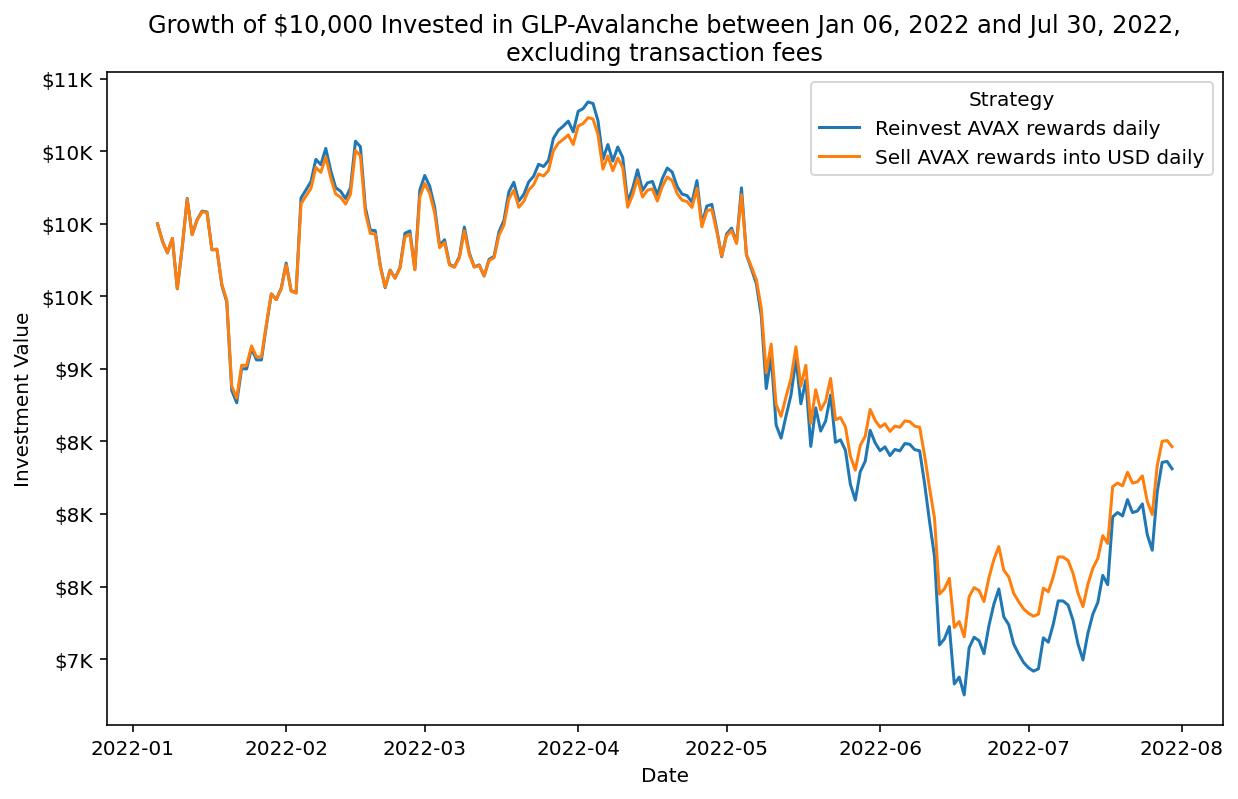

In [25]:
ax = sns.lineplot(data=df_long, x='Date', y='Investment Value', hue='Strategy')
ax.set(title="Growth of ${:,} Invested in GLP-{} between {} and {},\nexcluding transaction fees".format(init_capital, chain, start_date.strftime('%b %d, %Y'), last_day.strftime('%b %d, %Y'), reward_token))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

fname = 'glp_compare_2strats_since_{}.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);